In [51]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [52]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [53]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split(',') for i in sents]
    return sents

In [54]:
data = read_text("text.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [55]:
#deu_eng = deu_eng[:50000,:]

In [56]:
deu_eng

array([['strang', '  strange'],
       ['brake', '  break '],
       ['brack', '  break'],
       ['weanter', '  winter'],
       ['gost', '  ghost '],
       ['expect', '  except'],
       ['steped', '  stepped  '],
       ['streagh', '  strange  '],
       ['colow', '  coloured  '],
       ['exclation', '  escalator'],
       ['noicey', '  noticed '],
       ['fance', '  fence '],
       ['kille', '  kill  '],
       ['nerrow', '  arrow  '],
       ['depe', '  deep  '],
       ['gardon', '  garden  '],
       ['belu', '  blew  '],
       ['angray', '  angry  '],
       ['leavs', '  leaves '],
       ['manger', '  manager '],
       ['aero', '  arrow  '],
       ['ansion', '  ancient '],
       ['dear', '  deer '],
       ['flu', '  flew '],
       ['noice', '  noise'],
       ['stright', '  straight'],
       ['menes', '  means '],
       ['waight', '  waits'],
       ['arow', '  arrow '],
       ['dick', '  dig '],
       ['pice', '  piece'],
       ['tarpp', '  trap '],
       ['no

In [57]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [58]:
deu_eng

array([['strang', '  strange'],
       ['brake', '  break '],
       ['brack', '  break'],
       ['weanter', '  winter'],
       ['gost', '  ghost '],
       ['expect', '  except'],
       ['steped', '  stepped  '],
       ['streagh', '  strange  '],
       ['colow', '  coloured  '],
       ['exclation', '  escalator'],
       ['noicey', '  noticed '],
       ['fance', '  fence '],
       ['kille', '  kill  '],
       ['nerrow', '  arrow  '],
       ['depe', '  deep  '],
       ['gardon', '  garden  '],
       ['belu', '  blew  '],
       ['angray', '  angry  '],
       ['leavs', '  leaves '],
       ['manger', '  manager '],
       ['aero', '  arrow  '],
       ['ansion', '  ancient '],
       ['dear', '  deer '],
       ['flu', '  flew '],
       ['noice', '  noise'],
       ['stright', '  straight'],
       ['menes', '  means '],
       ['waight', '  waits'],
       ['arow', '  arrow '],
       ['dick', '  dig '],
       ['pice', '  piece'],
       ['tarpp', '  trap '],
       ['no

In [59]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()

In [60]:
deu_eng

array([['strang', '  strange'],
       ['brake', '  break '],
       ['brack', '  break'],
       ['weanter', '  winter'],
       ['gost', '  ghost '],
       ['expect', '  except'],
       ['steped', '  stepped  '],
       ['streagh', '  strange  '],
       ['colow', '  coloured  '],
       ['exclation', '  escalator'],
       ['noicey', '  noticed '],
       ['fance', '  fence '],
       ['kille', '  kill  '],
       ['nerrow', '  arrow  '],
       ['depe', '  deep  '],
       ['gardon', '  garden  '],
       ['belu', '  blew  '],
       ['angray', '  angry  '],
       ['leavs', '  leaves '],
       ['manger', '  manager '],
       ['aero', '  arrow  '],
       ['ansion', '  ancient '],
       ['dear', '  deer '],
       ['flu', '  flew '],
       ['noice', '  noise'],
       ['stright', '  straight'],
       ['menes', '  means '],
       ['waight', '  waits'],
       ['arow', '  arrow '],
       ['dick', '  dig '],
       ['pice', '  piece'],
       ['tarpp', '  trap '],
       ['no

In [61]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,1]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,0]:
    deu_l.append(len(i.split()))

In [62]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

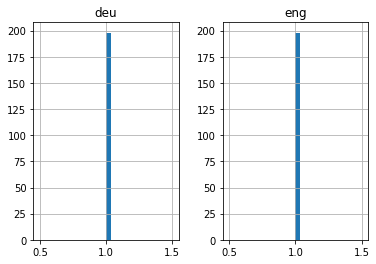

In [63]:
length_df.hist(bins = 30)
plt.show()

In [64]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [65]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 178


In [66]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 0])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 192


In [67]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [68]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [69]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 1])

In [70]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 1])

In [71]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [72]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [73]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 126 samples, validate on 32 samples
Epoch 1/30
126/126 [==============================] - 3s 28ms/step - loss: 5.1817 - val_loss: 5.1187

Epoch 00001: val_loss improved from inf to 5.11872, saving model to model.h1.24_jan_19
Epoch 2/30
126/126 [==============================] - 0s 2ms/step - loss: 5.0963 - val_loss: 4.7829

Epoch 00002: val_loss improved from 5.11872 to 4.78288, saving model to model.h1.24_jan_19
Epoch 3/30
126/126 [==============================] - 0s 2ms/step - loss: 4.4262 - val_loss: 3.2313

Epoch 00003: val_loss improved from 4.78288 to 3.23127, saving model to model.h1.24_jan_19
Epoch 4/30
126/126 [==============================] - 0s 2ms/step - loss: 2.0026 - val_loss: 2.2732

Epoch 00004: val_loss improved from 3.23127 to 2.27317, saving model to model.h1.24_jan_19
Epoch 5/30
126/126 [==============================] - 0s 3ms/step - loss: 1.1683 - val_loss: 2.0177

Epoch 00005: val_loss improved from 2.27317 to 2.01767, saving model to model.h1.24_jan_1

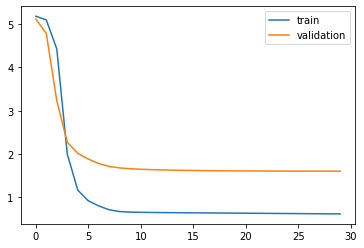

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [75]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [76]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [77]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [84]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [85]:
pd.set_option('display.max_colwidth', 200)

In [86]:
pred_df.head(15)

,actual,predicted
0,represents,
1,fence,
2,set,
3,crocodile,tried knives
4,thought,
5,ancient,
6,bubbles,
7,sudden,
8,strange,
9,dig,


In [87]:
pred_df.tail(15)

,actual,predicted
25,continue,
26,absorb,
27,trap,tried thunder knives
28,colour,
29,which,
30,tripped,
31,coming,
32,weight,
33,straight,
34,advertisements,


In [88]:
pred_df.tail(15)

,actual,predicted
25,continue,
26,absorb,
27,trap,tried thunder knives
28,colour,
29,which,
30,tripped,
31,coming,
32,weight,
33,straight,
34,advertisements,


In [89]:
pred_df.sample(15)

,actual,predicted
19,giraffe,
35,break,
29,which,
9,dig,
7,sudden,
16,opinion,
1,fence,
30,tripped,
25,continue,
28,colour,
